# Case study: Abadie Diamond Hainmueller (2015)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.utils import prepare_panel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from synthlearners.lbw import adelie_synth

In [4]:
adh_data = pd.read_csv("ADH2015.csv", index_col=0)
adh_data = adh_data[['country', 'year', 'gdp']]
# manually create treatment indicator
adh_data['treat'] = np.where((adh_data.country == "West Germany") & (adh_data.year > 1990), 1, 0)
adh_data.head()

,country,year,gdp,treat
index,,,,
1.0,USA,1960.0,2879,0
1.0,USA,1961.0,2929,0
1.0,USA,1962.0,3103,0
1.0,USA,1963.0,3227,0
1.0,USA,1964.0,3420,0


In [5]:
data = prepare_panel(
    adh_data,
    unit_col="country",
    time_col="year",
    outcome_col="gdp",
    treatment_col="treat",
)

Text(0.5, 1.0, 'Treatment matrix')

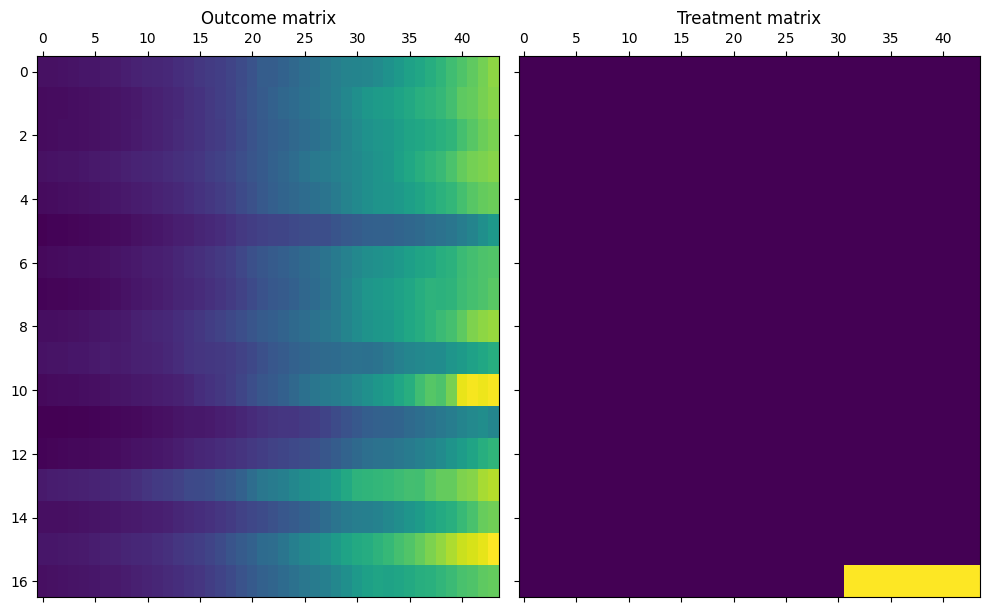

In [6]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

### Classic Synth

In [7]:
# Fit synthetic control
synth = Synth(method="simplex")
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

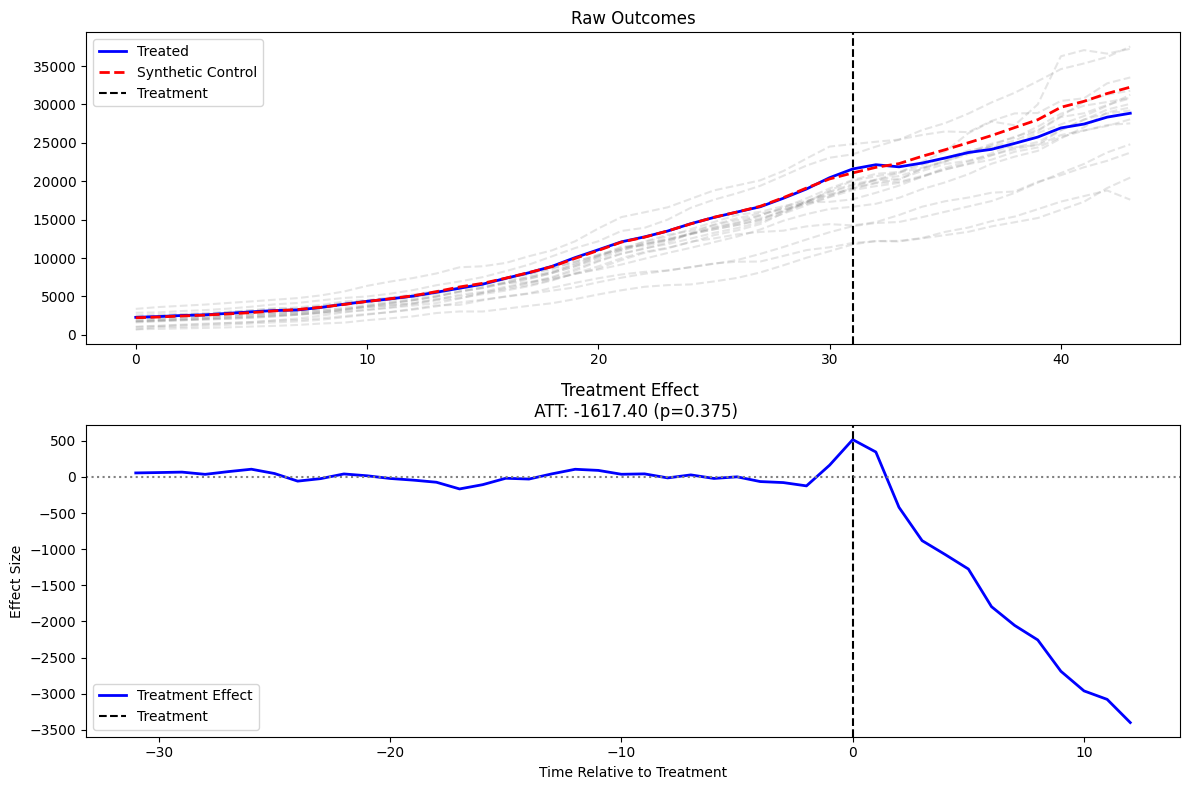

In [8]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
synth.plot(results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
synth.plot(
    results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

## Ridge Synth

Choosing regularization parameter using sequential cross-validation


You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

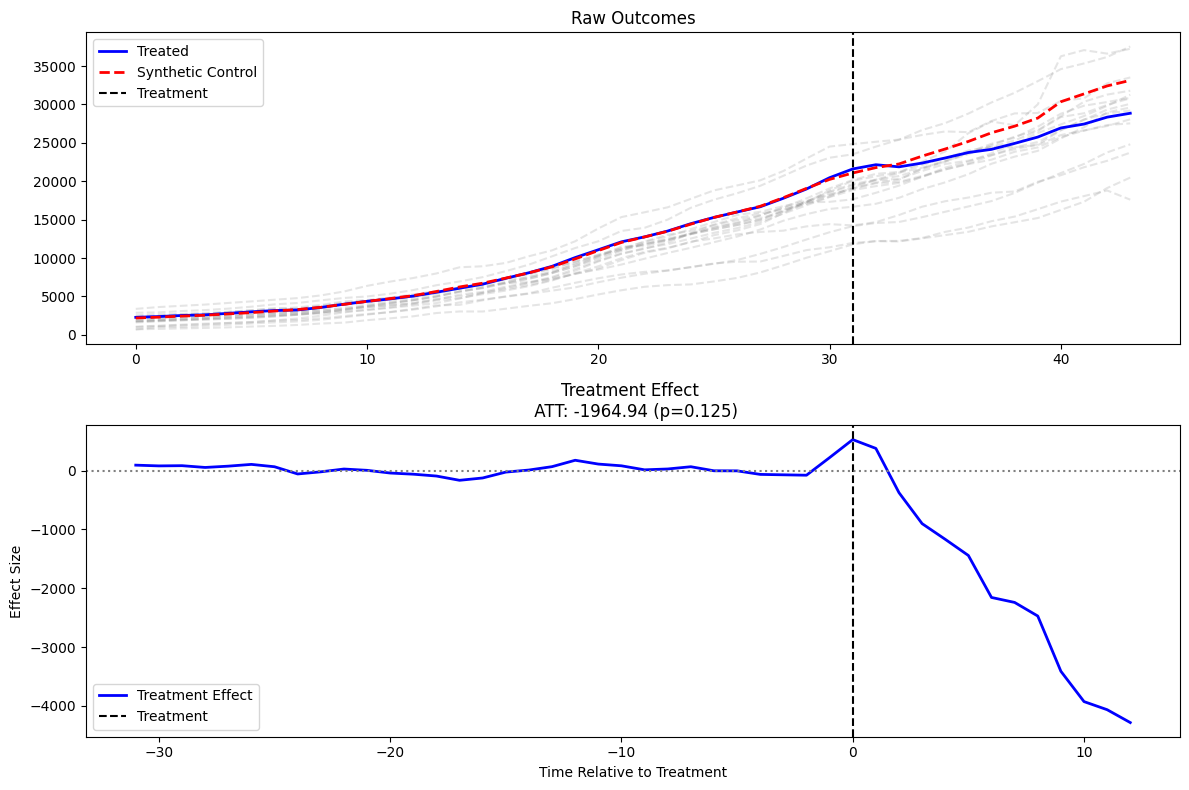

In [9]:
# Fit synthetic control
synth = Synth(method="lp_norm", p=2.0)
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
)
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
synth.plot(results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
synth.plot(
    results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [10]:
yy = data["Y"][data["treated_units"], :data["T_pre"]].squeeze().astype(float)
XX = np.delete(data["Y"], data["treated_units"], axis=0)[:, :data["T_pre"]].T.astype(float)
yy.shape, XX.shape

((31,), (31, 16))

In [11]:
ridge_sc_wts = adelie_synth(
    XX,
    yy,
    l1_ratio=0.0,
    intercept=True,
    noisy=False,
)

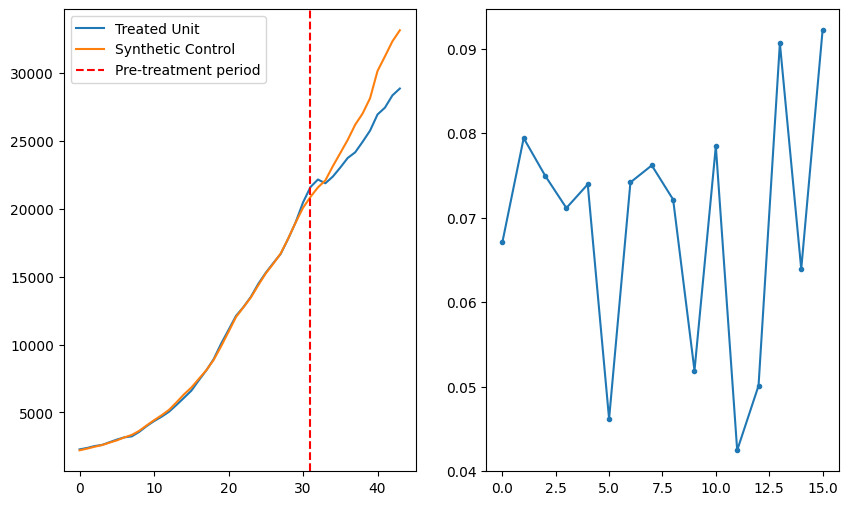

In [12]:
f, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(data["Y"][data["treated_units"]].squeeze(), label="Treated Unit")
ax[0].plot(
  ridge_sc_wts["fitter"](np.delete(data["Y"], data["treated_units"], axis = 0).T.astype(float)), label="Synthetic Control"
)
ax[0].axvline(
  data["T_pre"], color="red", linestyle="--", label="Pre-treatment period"
)
ax[0].legend()
ax[1].plot(ridge_sc_wts["weights"].squeeze(), marker='.')


### multiple synths

In [13]:
# Fit multiple synthetic controls
synth_methods = [
    Synth(method="lp_norm", p=1.0),
    Synth(method="lp_norm", p=2.0),
    Synth(method="linear"),
    Synth(method="simplex"),

]

results = [
    method.fit(data["Y"], data["treated_units"], data["T_pre"], compute_jackknife=False)
    for method in synth_methods
]

Choosing regularization parameter using sequential cross-validation
Choosing regularization parameter using sequential cross-validation


In [14]:
from synthlearners.plotting import SynthPlotter

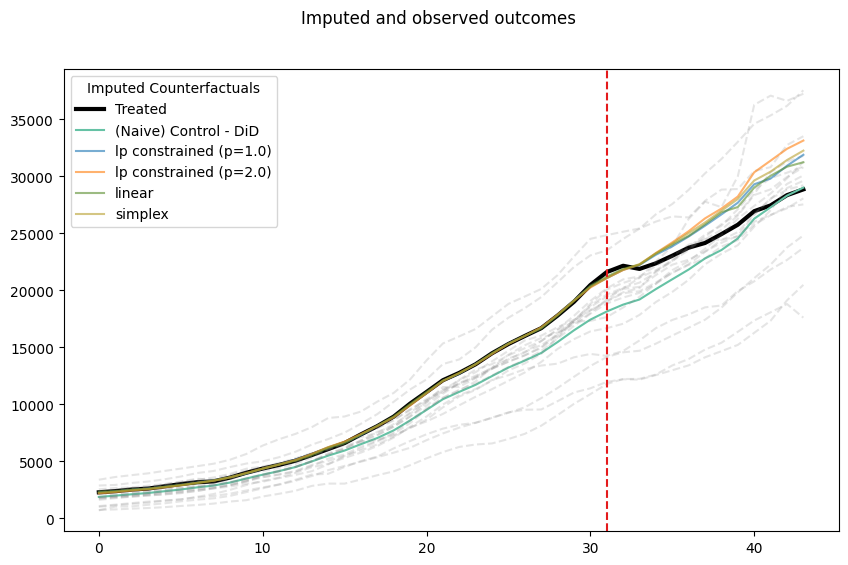

In [15]:
# Create plot
plotter = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_trajectories(
    results, data["Y"], data["treated_units"], data["T_pre"],
    ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes")
plt.show()

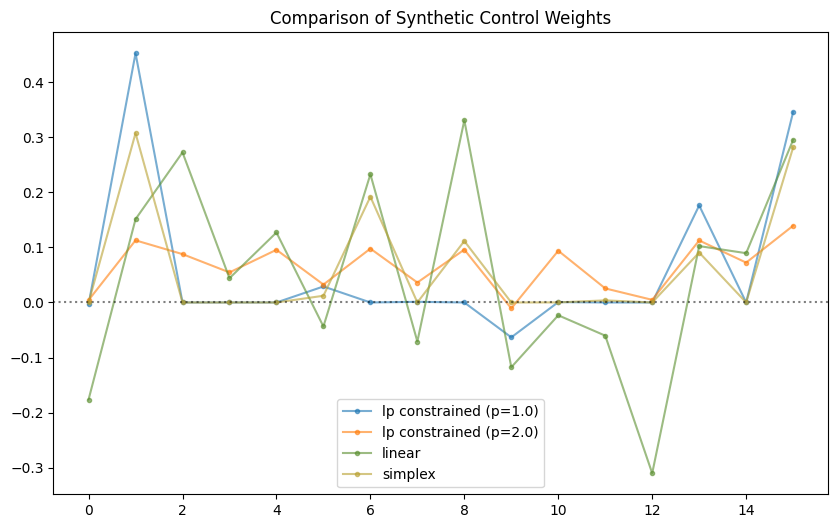

In [16]:
plotter.plot_weights(results, plot_type="comparison")
plt.show()

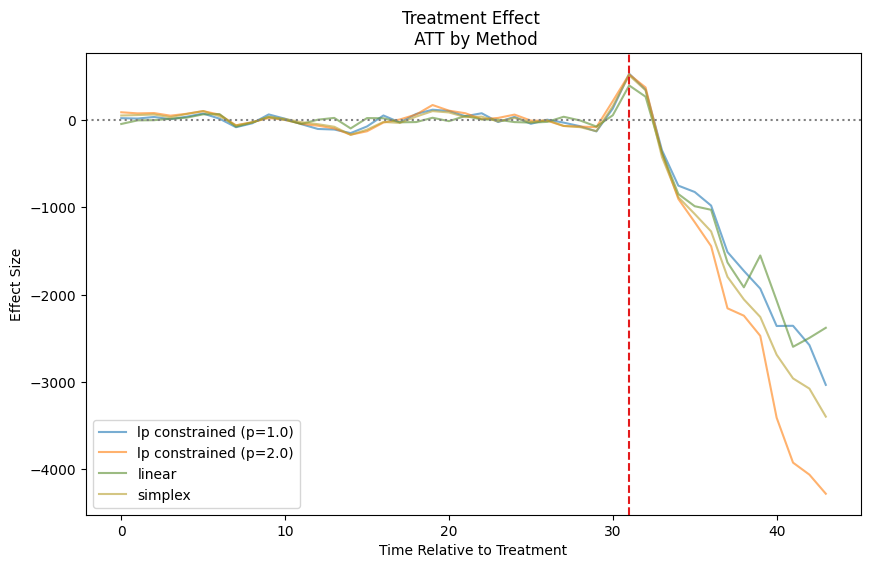

In [17]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_treatment_effects(results, data["T_pre"],ax=ax)
plt.show()